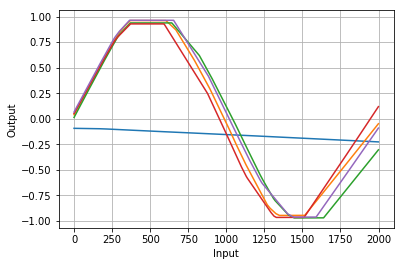

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def sigmoid(x):
	return 1./(1+np.exp(-x))

def relu(x):
	x[x<0.0] = 0.0
	return x

def deriv_relu(x):
	x[x>0.0] = 1.0
	return x

def tanh(x):
	return np.tanh(x)

def deriv_tanh(x):
	return (1-x**2)

def py_cal(mu_1, sigma_1, eps_1, mu_2, sigma_2, eps_2, mu_3, sigma_3, eps_3, 
	b_b1_mu, b_b1_logsigma, b_epsilon_b1,b_b2_mu, b_b2_logsigma, b_epsilon_b2,
	b_b3_mu, b_b3_logsigma, b_epsilon_b3, x_in, y_output, batch_size, n_batches, lr, b, episode_num):
	weight_1 = mu_1 + np.log(1. + np.exp(sigma_1))*eps_1
	weight_2 = mu_2 + np.log(1. + np.exp(sigma_2))*eps_2
	weight_3 = mu_3 + np.log(1. + np.exp(sigma_3))*eps_3
	b_weight_1 = b_b1_mu + np.log(1+np.exp(b_b1_logsigma))*b_epsilon_b1
	b_weight_2 = b_b2_mu + np.log(1+np.exp(b_b2_logsigma))*b_epsilon_b2
	b_weight_3 = b_b3_mu + np.log(1+np.exp(b_b3_logsigma))*b_epsilon_b3
	z1 = np.dot(x_in, weight_1) + b_weight_1
	h1 = relu(z1)
	z2 = np.dot(h1, weight_2) + b_weight_2 
	h2 = relu(z2)
	z3 = np.dot(h2, weight_3) + b_weight_3 
	# likelihood
	delta3 = -1.0*(1./x_in.shape[0])*(y_output-z3)/(np.exp(-3)**2) # we need to check (y-h) or (h-y)
	delta_b3_mu = np.sum(delta3, axis=0)
	delta_b3_logsigma = np.sum((delta3)*(1/(1+np.exp(-b_b3_logsigma)))*b_epsilon_b3, axis=0)
	delta_w3_mu = np.dot(h2.T, delta3)
	delta_w3_logsigma = np.dot(h2.T, delta3)*(1/(1+np.exp(-sigma_3)))*eps_3
	delta2 = np.dot(delta3, weight_3.T)*deriv_relu(h2)
	delta_b2_mu = np.sum(delta2, axis=0)
	delta_b2_logsigma = np.sum((delta2)*(1/(1+np.exp(-b_b2_logsigma)))*b_epsilon_b2, axis=0)
	delta_w2_mu = np.dot(h1.T, delta2)
	delta_w2_logsigma = np.dot(h1.T, delta2)*(1/(1+np.exp(-sigma_2)))*eps_2
	delta1 = np.dot(delta2, weight_2.T)*deriv_relu(h1)
	delta_b1_mu = np.sum(delta1, axis=0)
	delta_b1_logsigma = np.sum((delta1)*(1/(1+np.exp(-b_b1_logsigma)))*b_epsilon_b1, axis=0)
	delta_w1_mu = np.dot(x_in.T, delta1)
	delta_w1_logsigma = np.dot(x_in.T, delta1)*(1/(1+np.exp(-sigma_1)))*eps_1
	# prior 
	# wegihts
	w_gaussian_prior_mu_1 = -weight_1/(0.05**2)
	w_gaussian_prior_sigma_1 = (-weight_1/(0.05**2))* eps_1*(1./(1.+np.exp(-sigma_1)))
	w_gaussian_prior_mu_2 = -weight_2/(0.05**2)
	w_gaussian_prior_sigma_2 = (-weight_2/(0.05**2))* eps_2*(1./(1.+np.exp(-sigma_2)))
	w_gaussian_prior_mu_3 = -weight_3/(0.05**2)
	w_gaussian_prior_sigma_3 = (-weight_3/(0.05**2))* eps_3*(1./(1.+np.exp(-sigma_3)))
	# biases
	b_gaussian_prior_mu_1 = -b_weight_1/(0.05**2)
	b_gaussian_prior_sigma_1 = (-b_weight_1/(0.05**2))* b_epsilon_b1*(1./(1.+np.exp(-b_b1_logsigma)))
	b_gaussian_prior_mu_2 = -b_weight_2/(0.05**2)
	b_gaussian_prior_sigma_2 = (-b_weight_2/(0.05**2))* b_epsilon_b2*(1./(1.+np.exp(-b_b2_logsigma)))
	b_gaussian_prior_mu_3 = -b_weight_3/(0.05**2)
	b_gaussian_prior_sigma_3 = (-b_weight_3/(0.05**2))* b_epsilon_b3*(1./(1.+np.exp(-b_b3_logsigma)))
	
	# variational posterior only sigmas
	# sigmas for weights (mus for weights is zero in the case of Variational Posterior)
	varitional_sigma_1 = (-1.0/(np.log(1. + np.exp(sigma_1))))*(1/(1+np.exp(-sigma_1)))
	varitional_sigma_2 = (-1.0/(np.log(1. + np.exp(sigma_2))))*(1/(1+np.exp(-sigma_2)))
	varitional_sigma_3 = (-1.0/(np.log(1. + np.exp(sigma_3))))*(1/(1+np.exp(-sigma_3)))
	
	# sigmas for bias terms
	b_varitional_sigma_1 = (-1.0/(np.log(1+np.exp(b_b1_logsigma))))*(1/(1+np.exp(-b_b1_logsigma)))
	b_varitional_sigma_2 = (-1.0/(np.log(1+np.exp(b_b2_logsigma))))*(1/(1+np.exp(-b_b2_logsigma)))
	b_varitional_sigma_3 = (-1.0/(np.log(1+np.exp(b_b3_logsigma))))*(1/(1+np.exp(-b_b3_logsigma)))
	
	# mus and sigmas updates
	mu_1 = mu_1 - lr*((1./n_batches)*(0-w_gaussian_prior_mu_1)+(delta_w1_mu*x_in.shape[0]))*(1./x_in.shape[0])
	sigma_1 = sigma_1 - lr*((1./n_batches)*(varitional_sigma_1-w_gaussian_prior_sigma_1) + \
		(delta_w1_logsigma*x_in.shape[0]))*(1./x_in.shape[0])

	b_b1_mu = b_b1_mu - lr*((1./n_batches)*(0-b_gaussian_prior_mu_1)+(delta_b1_mu*x_in.shape[0]))*(1./x_in.shape[0])
	b_b1_logsigma = b_b1_logsigma - lr*((1./n_batches)*(b_varitional_sigma_1-b_gaussian_prior_sigma_1) + \
		(delta_b1_logsigma*x_in.shape[0]))*(1./x_in.shape[0])

	mu_2 = mu_2 - lr*((1./n_batches)*(0-w_gaussian_prior_mu_2)+ (delta_w2_mu*x_in.shape[0]))*(1./x_in.shape[0])
	sigma_2 = sigma_2 - lr*((1./n_batches)*(varitional_sigma_2-b_gaussian_prior_sigma_2) + \
		(delta_w2_logsigma*x_in.shape[0]))*(1./x_in.shape[0])

	b_b2_mu = b_b2_mu - lr*((1./n_batches)*(0-b_gaussian_prior_mu_2) + \
		(delta_b2_mu*x_in.shape[0]))*(1./x_in.shape[0])
	b_b2_logsigma = b_b2_logsigma - lr*((1./n_batches)*(b_varitional_sigma_2-b_gaussian_prior_sigma_2) + \
		(delta_b2_logsigma*x_in.shape[0]))*(1./x_in.shape[0])

	mu_3 = mu_3 - lr*((1./n_batches)*(0-w_gaussian_prior_mu_3)+(delta_w3_mu*x_in.shape[0]))*(1./x_in.shape[0])
	sigma_3 = sigma_3 - lr*((1./n_batches)*(varitional_sigma_3-w_gaussian_prior_sigma_3) + \
		(delta_w3_logsigma*x_in.shape[0]))*(1./x_in.shape[0])

	b_b3_mu = b_b3_mu - lr*((1./n_batches)*(0-b_gaussian_prior_mu_3)+(delta_b3_mu*x_in.shape[0]))*(1./x_in.shape[0])
	b_b3_logsigma = b_b3_logsigma - lr*((1./n_batches)*(b_varitional_sigma_3-b_gaussian_prior_sigma_3) + \
		(delta_b3_logsigma*x_in.shape[0]))*(1./x_in.shape[0])

	# this method returns the new mus and sigmas after updating
	return (mu_1, sigma_1, mu_2, sigma_2, mu_3, sigma_3, b_b1_mu, b_b1_logsigma, b_b2_mu, b_b2_logsigma, b_b3_mu, b_b3_logsigma)

if __name__ == '__main__':

	train_x = np.linspace(0,2*np.pi, num=2000,endpoint=True).reshape(2000,1)
	train_y = np.sin(train_x) + np.random.normal(loc=0.0, scale=0.01)

	sigma_prior = np.exp(-3)
	learning_rate = 0.0001 # from 0.001
	n_epochs = 5000
	M = train_x.shape[0]
	n_input = 1
	n_hidden_1 = 32*2
	n_hidden_2 = 32*2
	n_output = 1

	batch_size = 100
	n_batches = int(M / float(batch_size))

	mu_1 = np.random.normal(0, 0.05, size=(n_input, n_hidden_1))
	sigma_1 = np.random.normal(0, 0.05, size=(n_input, n_hidden_1))
	#eps_1 = np.random.normal(0, 0.05, size=(n_input, n_hidden_1))
	mu_2 = np.random.normal(0, 0.05, size=(n_hidden_1, n_hidden_2))
	sigma_2 = np.random.normal(0, 0.05, size=(n_hidden_1, n_hidden_2))
	#eps_2 = np.random.normal(0, 0.05, size=(n_hidden_1, n_hidden_2))
	mu_3 = np.random.normal(0, 0.05, size=(n_hidden_2, n_output))
	sigma_3 = np.random.normal(0, 0.05, size=(n_hidden_2, n_output))
	#eps_3 = np.random.normal(0, 0.05, size=(n_hidden_2, n_output))
	b_b1_mu = np.random.normal(0, 0.05, size=(1, n_hidden_1))
	b_b1_logsigma = np.random.normal(0, 0.05, size=(1, n_hidden_1))
	#b_epsilon_b1 = np.random.normal(0, 0.05, size=(1, n_hidden_1))
	b_b2_mu = np.random.normal(0, 0.05, size=(1, n_hidden_2))
	b_b2_logsigma = np.random.normal(0, 0.05, size=(1, n_hidden_2))
	#b_epsilon_b2 = np.random.normal(0, 0.05, size=(1, n_hidden_2))
	b_b3_mu = np.random.normal(0, 0.05, size=(1, n_output))
	b_b3_logsigma = np.random.normal(0, 0.05, size=(1, n_output))
	#b_epsilon_b3 = np.random.normal(0, 0.05, size=(1, n_output))

for e in range(n_epochs):
	errs = []

	for b in range(n_batches):
		x_input = train_x[b*batch_size:(b+1)*batch_size].reshape(batch_size,-1)
		y_true = train_y[b*batch_size:(b+1)*batch_size].reshape(batch_size, -1)
		eps_1 = np.random.normal(0, 0.05, size=(n_input, n_hidden_1))
		eps_2 = np.random.normal(0, 0.05, size=(n_hidden_1, n_hidden_2))
		eps_3 = np.random.normal(0, 0.05, size=(n_hidden_2, n_output))
		b_epsilon_b1 = np.random.normal(0, 0.05, size=(1, n_hidden_1))
		b_epsilon_b2 = np.random.normal(0, 0.05, size=(1, n_hidden_2))
		b_epsilon_b3 = np.random.normal(0, 0.05, size=(1, n_output))
		mu_1, sigma_1, mu_2, sigma_2, mu_3, sigma_3, b_b1_mu, b_b1_logsigma, b_b2_mu, b_b2_logsigma, b_b3_mu, b_b3_logsigma = \
		py_cal(mu_1, sigma_1, eps_1, mu_2, sigma_2, eps_2, mu_3, sigma_3, eps_3, b_b1_mu, b_b1_logsigma, b_epsilon_b1, b_b2_mu, \
			b_b2_logsigma, b_epsilon_b2, b_b3_mu, b_b3_logsigma, b_epsilon_b3, x_input, y_true, batch_size, n_batches, learning_rate, b, e)

	if e%1000 == 0.0:
		z1 = np.dot(train_x, mu_1) + b_b1_mu
		h1 = relu(z1)
		z2 = np.dot(h1, mu_2) + b_b2_mu 
		h2 = relu(z2)
		z3 = np.dot(h2, mu_3) + b_b3_mu
		#print('episode num', e)
		plt.plot(z3, label='BNN output')
		#plt.plot(train_y, label='True values')
		plt.xlabel('Input')
		plt.ylabel('Output')
		plt.grid()
		#plt.legend()
		#plt.clf()

## printing bayes and true output

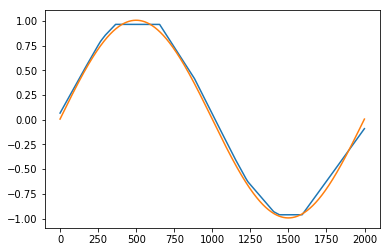

In [2]:
plt.plot(z3) # bayes output
plt.plot(train_y) # true output

## for calculating mu + log(1+np.exp(rho))*random_number

In [3]:
eps_1 = np.random.normal(0, 0.05, size=(n_input, n_hidden_1))
eps_2 = np.random.normal(0, 0.05, size=(n_hidden_1, n_hidden_2))
eps_3 = np.random.normal(0, 0.05, size=(n_hidden_2, n_output))
b_epsilon_b1 = np.random.normal(0, 0.05, size=(1, n_hidden_1))
b_epsilon_b2 = np.random.normal(0, 0.05, size=(1, n_hidden_2))
b_epsilon_b3 = np.random.normal(0, 0.05, size=(1, n_output))


weight_1 = mu_1 + eps_1*np.log(1. + np.exp(sigma_1))
weight_2 = mu_2 + eps_2*np.log(1. + np.exp(sigma_2))
weight_3 = mu_3 + eps_3*np.log(1. + np.exp(sigma_3))
b_weight_1 = b_b1_mu + b_epsilon_b1*np.log(1+np.exp(b_b1_logsigma))
b_weight_2 = b_b2_mu + b_epsilon_b2*np.log(1+np.exp(b_b2_logsigma))
b_weight_3 = b_b3_mu + b_epsilon_b3*np.log(1+np.exp(b_b3_logsigma))
z1 = np.dot(train_x, weight_1) + b_weight_1
h1 = relu(z1)
z2 = np.dot(h1, weight_2) + b_weight_2 
h2 = relu(z2)
z3_2 = np.dot(h2, weight_3) + b_weight_3

## for calculating mu + log(1+np.exp(rho))*random_number

In [4]:
weight_1 = mu_1 - eps_1*np.log(1. + np.exp(sigma_1))
weight_2 = mu_2 - eps_2*np.log(1. + np.exp(sigma_2))
weight_3 = mu_3 - eps_3*np.log(1. + np.exp(sigma_3))
b_weight_1 = b_b1_mu - b_epsilon_b1*np.log(1+np.exp(b_b1_logsigma))
b_weight_2 = b_b2_mu - b_epsilon_b2*np.log(1+np.exp(b_b2_logsigma))
b_weight_3 = b_b3_mu - b_epsilon_b3*np.log(1+np.exp(b_b3_logsigma))

z1 = np.dot(train_x, weight_1) + b_weight_1
h1 = relu(z1)
z2 = np.dot(h1, weight_2) + b_weight_2 
h2 = relu(z2)
z3_3 = np.dot(h2, weight_3) + b_weight_3

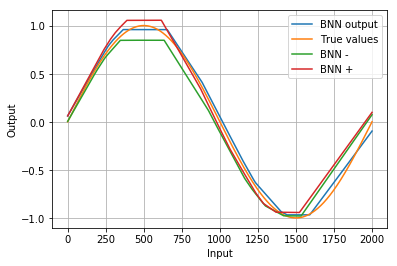

In [5]:
plt.plot(z3, label='BNN output')
plt.plot(train_y, label='True values')
plt.plot(z3_3, label='BNN - ')
plt.plot(z3_2, label='BNN + ')
plt.xlabel('Input')
plt.ylabel('Output')
plt.grid()
plt.legend()